# Sensitivity-regularized control synthesis

Goal: develop a rapid prototype of a control optimization system that uses a sensitivity-regularized optimization scheme.

Sub-goals:
- Implement a differentiable simulator for a simple continuous control task, taking in design parameters (control gains) and exogenous parameters (disturbances) and returning a cost (distance from goal after some amount of time).
- Implement a wrapper around the differentiable simulator that gets the cost (autodiff'd) and the derivative of that cost w.r.t. the exogenous parameters (also autodiff'd).
- Implement a gradient-based optimization scheme for finding design parameters that robustly optimize the cost.

## A Differentiable Simulator

This simulates a simple continuous control task using PyTorch (enabling easy autodiff). The task is to navigate a 2D quadrotor to the origin starting from a given point. There is wind blowing in the -x direction, which applies a lift and drag to the quadrotor (modelled as a flat plate).

In [2]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch

In [141]:
# Define the simulator function
def simulate(
    design_parameters: torch.Tensor,
    exogenous_parameters: torch.Tensor,
    time_horizon: float = 5.0,
    time_step: float = 1e-2,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulates the performance of the system over the specified time horizon and
    returns the cost, which is twice differentiable using PyTorch autodiff tools.
    
    Calls to the simulator may be batched.
    
    The system is the 2D quadrotor, with state [px, pz, theta, vx, vz, theta_dot],
    control inputs [u_left, u_right], and exogenous parameter giving the wind speed
    in the -x direction [w].
    
    We use simplified flat plate aerodynamics as in
    http://underactuated.mit.edu/trajopt.html#perching
    
    args:
        design_parameters: (14,) or (N, 14) tensor giving linear feedback control gains,
                           where the first 6 values are the first row of K, the next 6
                           are the second row, and the last 2 values are u_0 (defined so
                           that u = -K @ x + u_0)
        exogenous_parameters: (1,) or (N, 1) tensor of wind speeds. If batched, must have
                              the same batch size as design_parameters.
    returns:
        A tuple of cost and the state of the system over the course of the simulation
    """
    # If inputs are not batched, reshape to have a batch dimension
    if design_parameters.ndim == 1:
        design_parameters = design_parameters.reshape(1, -1)
    if exogenous_parameters.ndim == 1:
        exogenous_parameters = exogenous_parameters.reshape(1, -1)
    
    # If design parameters were batched, make sure the exogenous params match
    batch_size = 1
    if design_parameters.shape[0] > 1:
        batch_size = design_parameters.shape[0]
        
        # If the other input is also batched, it must match
        if exogenous_parameters.shape[0] > 1:
            error_msg = f"Design params batched with size {batch_size}, but "
            error_msg += f"exogenous params batched with size {exogenous_parameters.shape[0]}"
            assert batch_size == exogenous_parameters.shape[0], error_msg
        else:
            # Otherwise, repeat the exogenous parameters to match
            exogenous_parameters = exogenous_parameters.repeat(batch_size, 1)
    elif exogenous_parameters.shape[0] > 1:
        # Otherwise, if exogenous params were batched,
        # make sure design params match
        batch_size = exogenous_parameters.shape[0]
        
        # If the other input is also batched, it must match
        if design_parameters.shape[0] > 1:
            error_msg = f"Exogenous params batched with size {batch_size}, but "
            error_msg += f"design params batched with size {design_parameters.shape[0]}"
            assert batch_size == design_parameters.shape[0], error_msg
        else:
            # Otherwise, repeat the design parameters to match
            design_parameters = design_parameters.repeat(batch_size, 1)
            
    # Define the physical parameters
    n_dims = 6
    n_controls = 2
    mass = 0.1  # kg
    gravity = 9.81  # m/s^2
    inertia = 0.001  # kg-m^2
    r = 0.05  # m, distance from center to propeller
    rho_air = 1.205  # kg / m^3
    A = 0.01  # m^2 -- characteristic area of quadrotor
    
    # Get the control law from the design parameters
    K = design_parameters[:, :12].reshape(-1, n_controls, n_dims)
    u_0 = design_parameters[:, 12:].reshape(-1, n_controls, 1)
    
    # Create tensors to store the simulated state and controls
    n_steps = int(time_horizon // time_step) + 1
    q = torch.zeros(n_steps, batch_size, n_dims)
    u = torch.zeros(n_steps, batch_size, n_controls)
    
    # Set the initial state stationary at px = -1, all other states 0
    q[0, :, 0] = 1.0
    q[0, :, 1] = 1.0
    q[0, :, 2] = 1.0
    
    # Simulate forward
    for t_step in range(n_steps - 1):
        # Get the current state
        q_current = q[t_step].reshape(-1, n_dims, 1)
        px = q_current[:, 0, 0]
        pz = q_current[:, 1, 0]
        theta = q_current[:, 2, 0]
        vx = q_current[:, 3, 0]
        vz = q_current[:, 4, 0]
        theta_dot = q_current[:, 5, 0]
        
        # Get the control input
        u[t_step] = (u_0 - torch.bmm(K, q_current)).reshape(-1, n_controls)
        u_current = u[t_step].reshape(-1, n_controls, 1)
        
        # Get the aerodynamic force magnitude
        w = exogenous_parameters
        v_wind = torch.hstack((-w, torch.zeros_like(w))).reshape(-1, 2, 1)
        v = q_current[:, 3:5, :] - v_wind  # apparent vehicle velocity
        n = torch.vstack((-torch.sin(theta), torch.cos(theta))).T.reshape(-1, 2, 1)
        n = n.transpose(1, 2)
        f_aero = rho_air * A * (n @ v) * v.norm(dim=1).unsqueeze(-1)
        f_aero = f_aero.squeeze()  # should be (batch_size,)
        
        # Update the states
        # Positions are just updated using velocities
        q[t_step + 1, :, 0] = px + time_step * vx
        q[t_step + 1, :, 1] = pz + time_step * vz
        q[t_step + 1, :, 2] = theta + time_step * theta_dot
        
        # x velocity is updated from control input and drag
        f_control_x = -u_current.squeeze().sum(dim=-1) * torch.sin(theta)
        f_drag_x = f_aero * torch.sin(theta)
        f_x = f_control_x + f_drag_x
        q[t_step + 1, :, 3] = vx + time_step * f_x / mass
        
        # z velocity is updated from control input, lift, and gravity
        f_control_z = u_current.squeeze().sum(dim=-1) * torch.cos(theta)
        f_grav_z = -mass * gravity * torch.ones_like(f_control_z)
        f_lift_z = f_aero * torch.cos(theta)
        f_z = f_control_z + f_lift_z + f_grav_z
        q[t_step + 1, :, 4] = vz + time_step * f_z / mass
        
        # Theta is updated from the control input alone
        tau_control_theta = r * (u_current[:, 0, 0] - u_current[:, 1, 0])
        tau_theta = tau_control_theta
        q[t_step + 1, :, 5] = theta_dot + time_step * tau_theta / inertia
        
    # Compute the cost based on the LQR state cost
    cost = (q[:, :, :] ** 2).sum(dim=-1).sum(dim=0) * time_step
    
    # Return the cost and trajectory
    return cost, q

Let's see how this simulation performs! We can use a placeholder control policy based on LQR; this won't work particularly well, but we can at least see what happens!

Cost with wind 0.0 m/s = tensor([13.4876])
Cost with wind 5.0 m/s = tensor([15.1149])


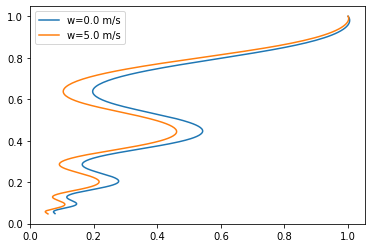

In [142]:
def get_2d_quad_lqr():
    mass = 0.1  # kg
    inertia = 0.001  # kg-m^2
    r = 0.05  # m, distance from center to propeller

    # Define linearized dynamics
    A = np.zeros((6, 6))
    A[:3, 3:] = np.eye(3)
    A[3, 2] = -0.981
    
    B = np.zeros((6, 2))
    B[4, :] = r / mass
    B[5, 0] = r / inertia
    B[5, 1] = -r / inertia
    
    # Define cost matrices
    Q = 2 * np.eye(6)
    R = np.eye(2)
    
    # Solve Ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))
    
    return K

dp = torch.zeros(1, 14)
dp[:, 12:] += 0.981 / 2.0
dp[:, :12] += torch.tensor(get_2d_quad_lqr()).reshape(1, 12)
ep = torch.ones(1, 1)

w1 = 0.0
w2 = 5.0
cost, q1 = simulate(dp, w1 * ep, time_horizon=5.0)
print(f"Cost with wind {w1} m/s = {cost}")

cost, q2 = simulate(dp, w2 * ep, time_horizon=5.0)
print(f"Cost with wind {w2} m/s = {cost}")

plt.plot(q1[:, 0, 0], q1[:, 0, 1], label=f"w={w1} m/s")
plt.plot(q2[:, 0, 0], q2[:, 0, 1], label=f"w={w2} m/s")
plt.legend()

## First-order optimization

Let's take a look at how well the baseline controller's performance changes as a function of wind speed.

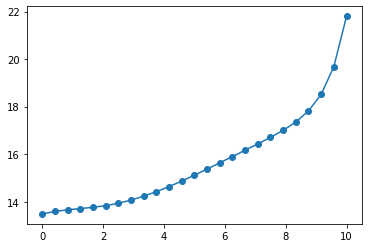

In [132]:
dp = torch.zeros(1, 14)
dp[:, 12:] += 0.981 / 2.0
dp[:, :12] += torch.tensor(get_2d_quad_lqr()).reshape(1, 12)
n_trials = 25
ep = torch.linspace(0.0, 10.0, n_trials).reshape(n_trials, 1)

costs, qs = simulate(dp, ep, time_horizon=5.0)

plt.plot(ep[:, 0], costs, "o-")

A plot like this begs two questions. 1: How can we optimize our controller to work better at a given windspeed? 2: How can we optimize our controller to be *less sensitive* to the changes in wind speed.

Let's try to answer the first question here.

In [140]:
# Initialize our controller with a guess from LQR, but enable grad so we can optimize
dp = torch.zeros(1, 14)
dp[:, 12:] += 0.981 / 2.0
dp[:, :12] += torch.tensor(get_2d_quad_lqr()).reshape(1, 12)
dp.requires_grad = True
# Save the initial guess for posterity
dp_0 = dp.clone().detach()

# Also pick a wind-speed to operate in
ep = 4.0 * torch.ones(1, 1)

# Set up some details for a gradient-descent-based optimization
n_steps = 100
learning_rate = 1e-3

torch.autograd.set_detect_anomaly(True)
cost, _ = simulate(dp, ep, time_horizon=0.1, time_step=0.1)
cost.backward()
dp

tensor(-0.1622)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn